In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
from tensorflow import keras
%matplotlib inline

# Dataset

This data was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. For more information about the dataset, please refer to the link :

https://archive.ics.uci.edu/ml/datasets/in-vehicle+coupon+recommendation#

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets-main/ivcr_s2.csv")
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y
0,Home,Alone,Sunny,55,6PM,Restaurant(20-50),1d,1,21,Married partner,...,never,gt8,1~3,gt8,1~3,1,1,0,0,0
1,Home,Alone,Sunny,30,6PM,Carry out & Take away,1d,1,31,Single,...,never,1~3,1~3,1~3,less1,1,0,0,0,1
2,No Urgent Place,Alone,Sunny,80,10AM,Coffee House,2h,1,50plus,Married partner,...,never,never,4~8,less1,1~3,1,1,0,0,0
3,No Urgent Place,Friend(s),Sunny,80,2PM,Restaurant(20-50),1d,0,31,Single,...,never,less1,less1,less1,less1,1,1,0,0,1
4,Work,Alone,Sunny,80,7AM,Carry out & Take away,2h,0,50plus,Married partner,...,never,never,less1,1~3,less1,1,0,0,1,0


In [ ]:
int_cols = ['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min','direction_same','gender','Y']
for col in df.columns:
  if col not in int_cols:
    df[col] = df[col].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   destination           12684 non-null  category
 1   passanger             12684 non-null  category
 2   weather               12684 non-null  category
 3   temperature           12684 non-null  int64   
 4   time                  12684 non-null  category
 5   coupon                12684 non-null  category
 6   expiration            12684 non-null  category
 7   gender                12684 non-null  int64   
 8   age                   12684 non-null  category
 9   maritalStatus         12684 non-null  category
 10  has_children          12684 non-null  int64   
 11  education             12684 non-null  category
 12  occupation            12684 non-null  category
 13  income                12684 non-null  category
 14  Bar                   12684 non-null  category
 15  Co

# EDA

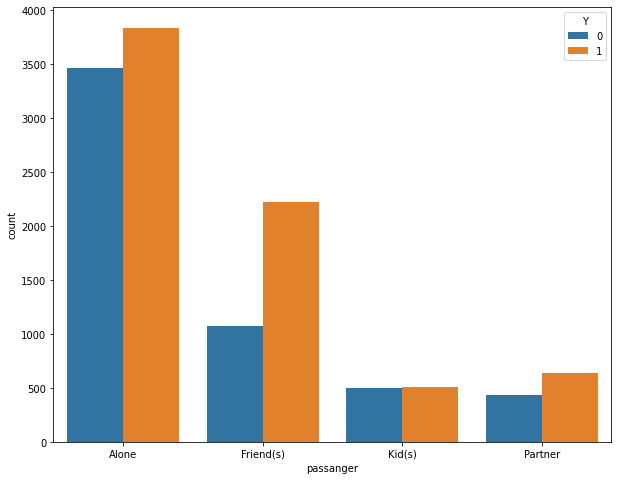

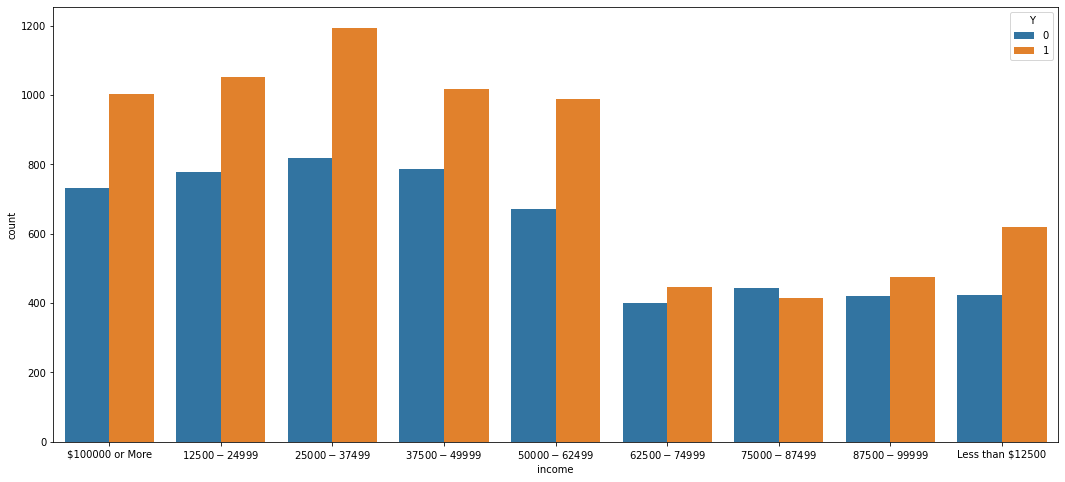

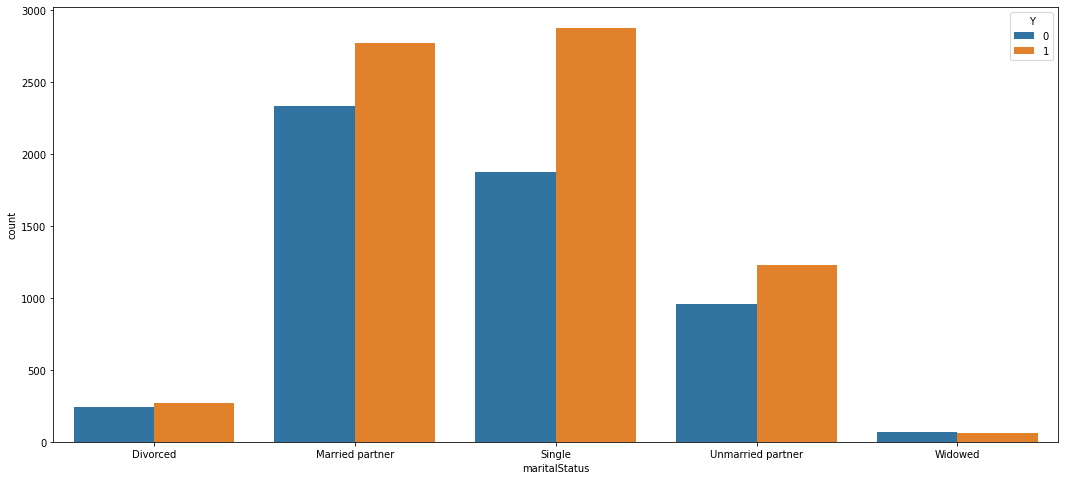

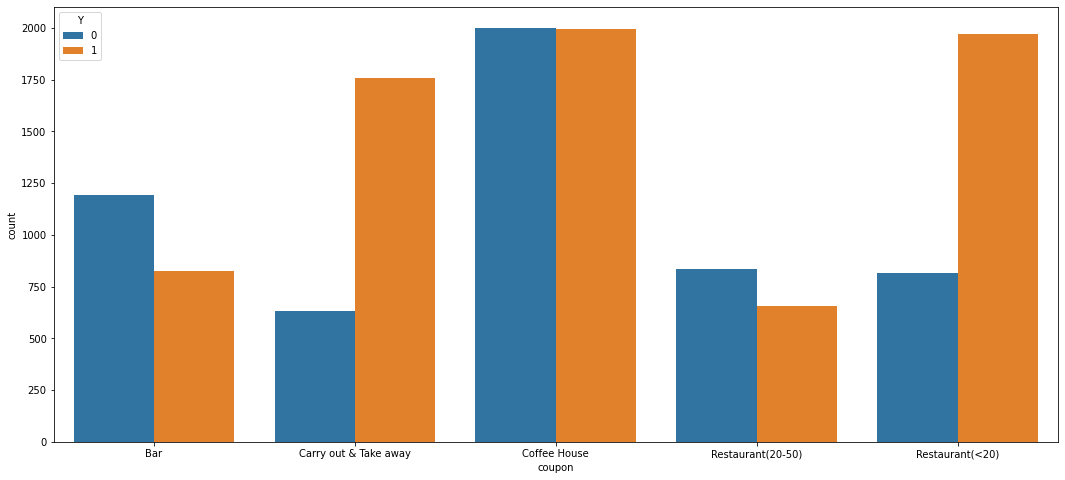

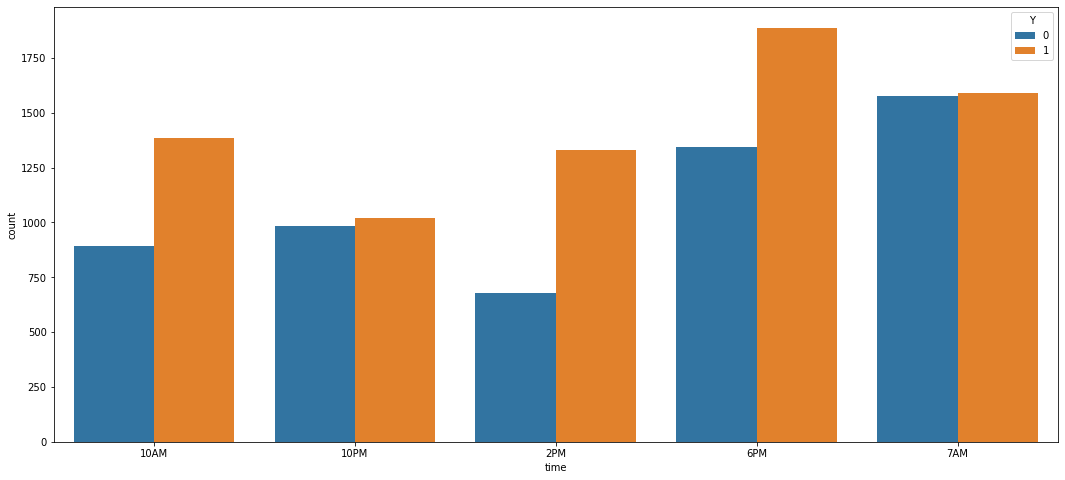

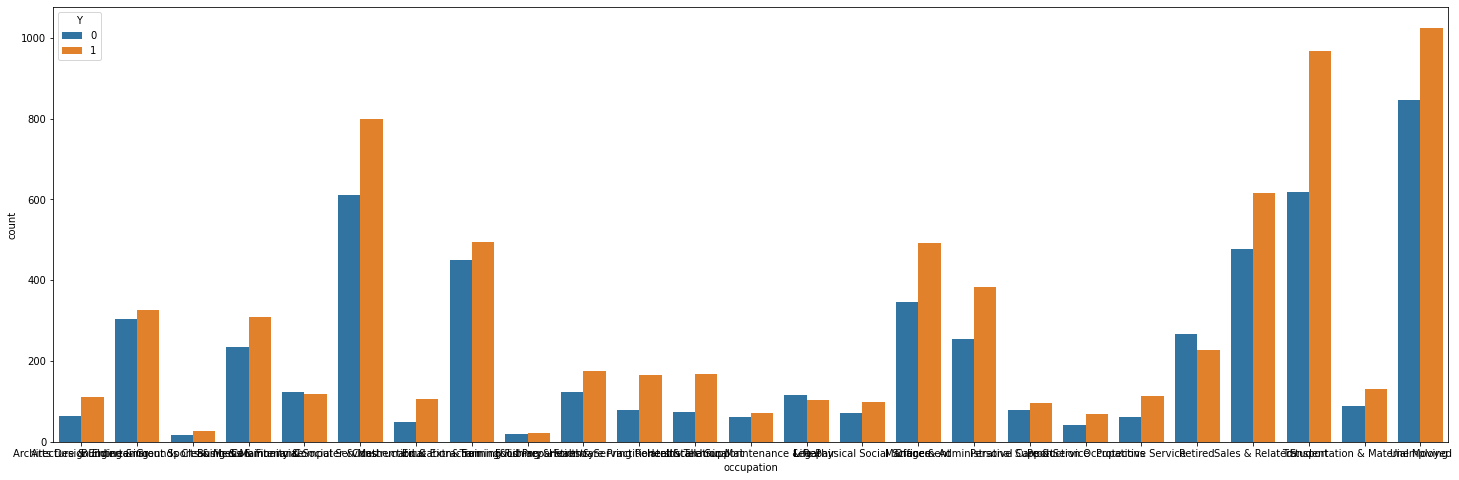

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(x='passanger', hue='Y', data=df)

plt.figure(figsize=(18,8))
sns.countplot(x='income', hue='Y', data=df)

plt.figure(figsize=(18,8))
sns.countplot(x='maritalStatus', hue='Y', data=df)

plt.figure(figsize=(18,8))
sns.countplot(x='coupon', hue='Y', data=df)

plt.figure(figsize=(18,8))
sns.countplot(x='time', hue='Y', data=df)

plt.figure(figsize=(25,8))
ax = sns.countplot(x='occupation', hue='Y', data=df)
xticklabels = ax.get_xticklabels()
for i in range(len(xticklabels)):
  text = xticklabels[i].get_text()[:15]
  xticklabels[i].set_text(text)
  #print(xticklabels[i].get_text())

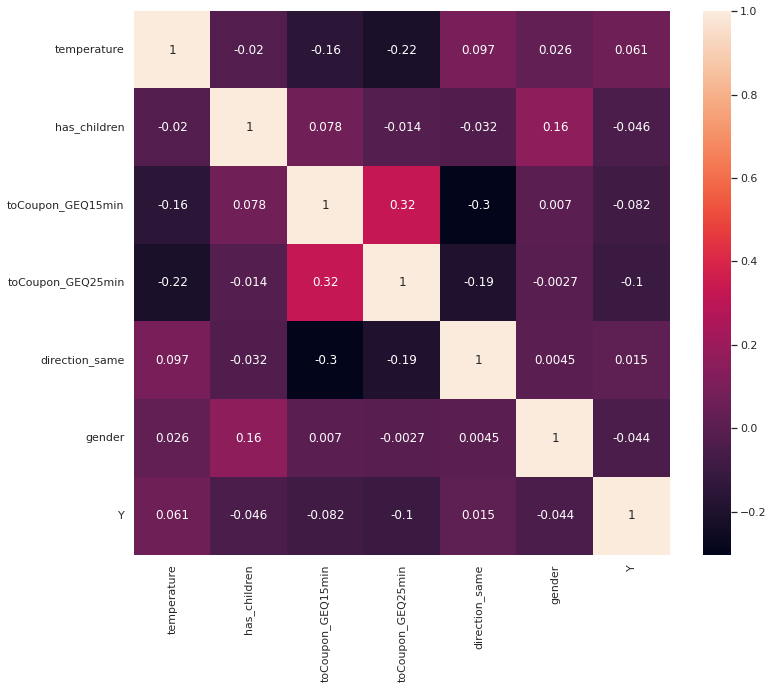

In [ ]:
# Correlation matrix of numerical features

cor_cols = int_cols
cor_cols.remove("toCoupon_GEQ5min") # toCoupon_GEQ5min is missing, because it produces NaNs(for some weird reason) in the correlation matrix
sns.set(rc = {'figure.figsize':(12,10)})
sns.heatmap(df[cor_cols].corr(), annot=True)
plt.show()

# Balance, Split, Train, Test

In [ ]:
# Import necessary ML-tools
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from matplotlib.pyplot import figure
from xgboost import XGBClassifier
from yellowbrick.model_selection import learning_curve

In [ ]:
# Do one-hot encoding for categorical features
int_cols = ['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min','direction_same','gender','Y']
for col in df.columns:
  if col not in int_cols:
    df = pd.get_dummies(data=df, columns=[col])
print(df.shape,"\n", df.dtypes)

(12684, 108) 
 temperature               int64
gender                    int64
has_children              int64
toCoupon_GEQ5min          int64
toCoupon_GEQ15min         int64
                          ...  
Restaurant20To50_1~3      uint8
Restaurant20To50_4~8      uint8
Restaurant20To50_gt8      uint8
Restaurant20To50_less1    uint8
Restaurant20To50_never    uint8
Length: 108, dtype: object


In [ ]:
# Balance the dataset, encode the label, and scale the feature
X = df.drop(['Y'], axis = 1)
Y = df['Y'].copy()

from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_sm, Y_sm = smote.fit_resample(X, Y)
print(X.shape, Y.shape)
print(X_sm.shape, Y_sm.shape)

Y = LabelEncoder().fit_transform(Y_sm)
X = StandardScaler().fit_transform(X_sm)

(12684, 107) (12684,)
(14420, 107) (14420,)


In [ ]:
# Define a few functions which incorporate split, train, test, plot routine

def run_xgb_XY(X, Y, title):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                      test_size = 0.2, 
                                                      random_state = 101)
  start = time.process_time()
  model = XGBClassifier(n_estimators=1000).fit(X_train, Y_train)
  print("Training time: ", '%.1f'%(time.process_time() - start))
  predictions = model.predict(X_test)
  #display_train_test_curves(model, X, Y)
  display_roc_auc(model, X_test, Y_test, title)
  print(classification_report(Y_test, predictions))
  ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test)

def run_xgb(d_frame, title):
  X = d_frame.drop(['Y'], axis = 1)
  Y = d_frame['Y']
  Y = LabelEncoder().fit_transform(Y)
  X = StandardScaler().fit_transform(X)

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                      test_size = 0.2, 
                                                      random_state = 101)
  start = time.process_time()
  model = XGBClassifier(n_estimators=1000).fit(X_train, Y_train)
  print("Training time: ", '%.1f'%(time.process_time() - start))
  predictions = model.predict(X_test)
  #display_train_test_curves(model, X, Y)
  display_roc_auc(model, X_test, Y_test, title)
  print(classification_report(Y_test, predictions))
  ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test)
  return model

In [ ]:
# Helper function
def display_roc_auc(model, X_test, y_test, title):
  lr_probs = model.predict_proba(X_test)[:, 1]
  ns_probs = [_ for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)
  lr_auc = roc_auc_score(y_test, lr_probs)
  print('Guess: ROC AUC=%.3f' % (ns_auc))
  print('Logistic: ROC AUC=%.3f' % (lr_auc))
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
  pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess')
  pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
  pyplot.title(title)
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.legend()
  pyplot.show()

def display_train_test_curves(model, X, Y):
  print(learning_curve(model, X, Y, cv=5, scoring='accuracy'))

Training time:  32.5
Guess: ROC AUC=0.501
Logistic: ROC AUC=0.866


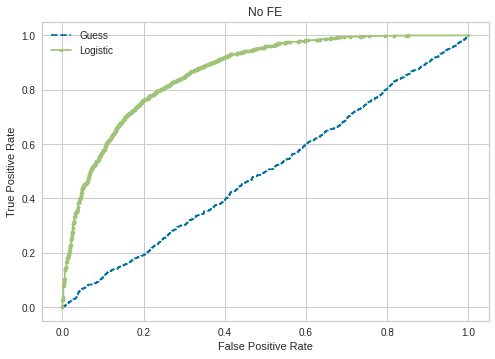

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1430
           1       0.78      0.80      0.79      1454

    accuracy                           0.78      2884
   macro avg       0.78      0.78      0.78      2884
weighted avg       0.78      0.78      0.78      2884



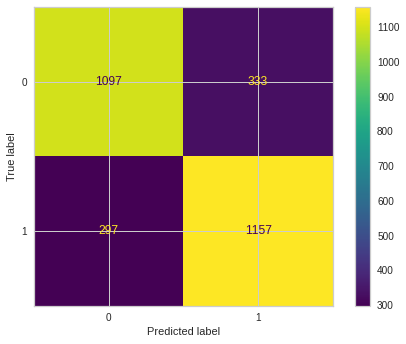

In [ ]:
# Balanced df
xgb_model = run_xgb_XY(X, Y, 'No FE')

# PCA

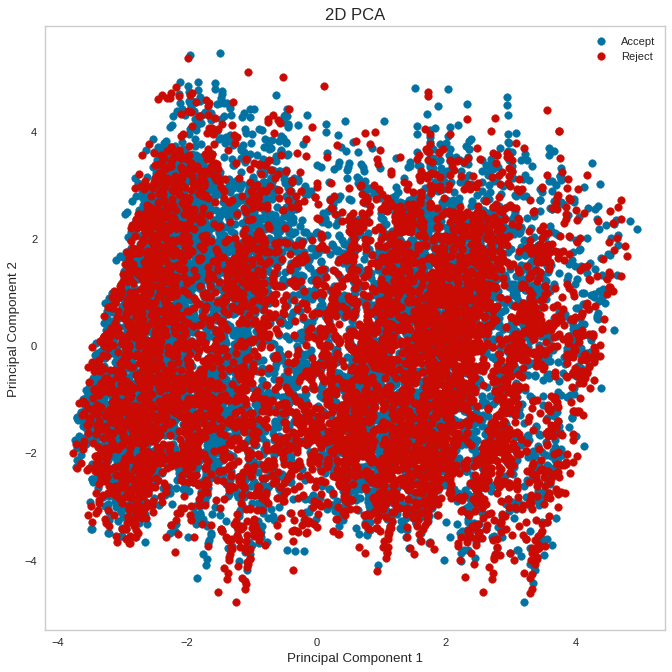

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
PCA_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
PCA_df = pd.concat([PCA_df, df['Y']], axis = 1)
PCA_df['Y'] = LabelEncoder().fit_transform(PCA_df['Y'])

figure(num=None, figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
classes = [1, 0]
colors = ['b', 'r']
for c1, color in zip(classes, colors):
  plt.scatter(PCA_df.loc[PCA_df['Y'] == c1, 'PC1'],
              PCA_df.loc[PCA_df['Y'] == c1, 'PC2'],
              c = color)
plt.xlabel('Principal Component 1', fontsize = 12)
plt.ylabel('Principal Component 2', fontsize = 12)
plt.title('2D PCA', fontsize = 15)
plt.legend(['Accept', 'Reject'])
plt.grid()

[0.04128162 0.0330114  0.02723714 0.02659996 0.02336552 0.02297373
 0.02078276 0.02003743 0.01935206 0.01895708 0.01805192 0.01728797
 0.01675293 0.01647727 0.01599208 0.01562318 0.01495192 0.014693
 0.01449773 0.01424912 0.01392353 0.01371329 0.01349655 0.01336922
 0.01322655 0.01285775 0.01267591 0.01255337 0.01245133 0.01227869
 0.0118947  0.01164796 0.01141358 0.0112903  0.01093182 0.0108095
 0.01062783 0.01045734 0.01034191 0.01019103 0.01015963 0.00995773
 0.00973302 0.00967736 0.00951089 0.00943783 0.00933184 0.00926321
 0.00899167 0.00878542]


Text(0, 0.5, 'Cumulative explained variance')

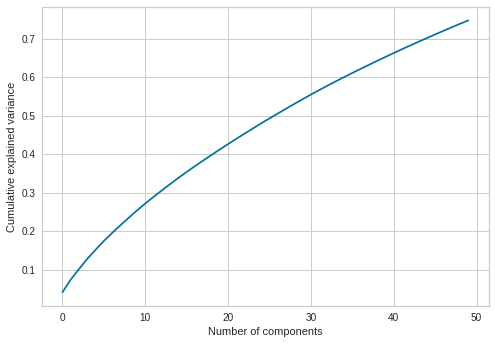

In [ ]:
pca2 = PCA(n_components=50)
pca2.fit_transform(X)
print(pca2.explained_variance_ratio_)
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [ ]:
initial_features_names = list(df.columns)
initial_features_names.remove('Y')
n_pcs = pca2.components_.shape[0]
most_important_names = [np.abs(pca2.components_[i]).argmax() for i in range(n_pcs)]
comp_names = []
init_idxs = []
feat_names = []
expl_var = []
for i in range(n_pcs):
  comp_names.append('PC{}'.format(i))
  init_idxs.append(most_important_names[i])
  feat_names.append(initial_features_names[most_important_names[i]])
  expl_var.append(pca2.explained_variance_ratio_[i])
comps = pd.DataFrame(columns=['Component', 'Initial Index', 'Feature Name', 'Explained Variance'])
comps['Component'] = comp_names
comps['Initial Index'] = init_idxs
comps['Feature Name'] = feat_names
comps['Explained Variace'] = expl_var

comps.head(20)

,Component,Initial Index,Feature Name,Explained Variance,Explained Variace
0,PC0,8,destination_No Urgent Place,NaN,0.041282
1,PC1,38,maritalStatus_Married partner,NaN,0.033011
2,PC2,86,Bar_never,NaN,0.027237
3,PC3,16,weather_Sunny,NaN,0.026600
4,PC4,7,destination_Home,NaN,0.023366
5,PC5,35,age_50plus,NaN,0.022974
6,PC6,93,CarryAway_4~8,NaN,0.020783
7,PC7,47,education_Some college - no degree,NaN,0.020037
8,PC8,28,expiration_2h,NaN,0.019352
9,PC9,27,expiration_1d,NaN,0.018957


Training time:  14.7
Guess: ROC AUC=0.501
Logistic: ROC AUC=0.818


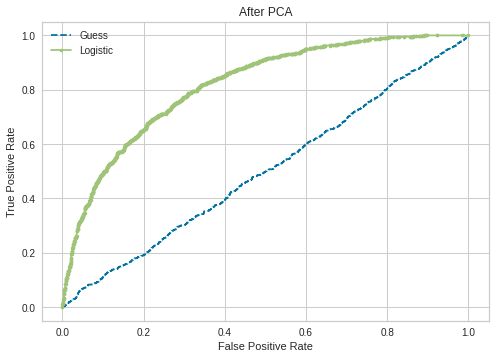

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1430
           1       0.73      0.75      0.74      1454

    accuracy                           0.74      2884
   macro avg       0.74      0.73      0.74      2884
weighted avg       0.74      0.74      0.74      2884



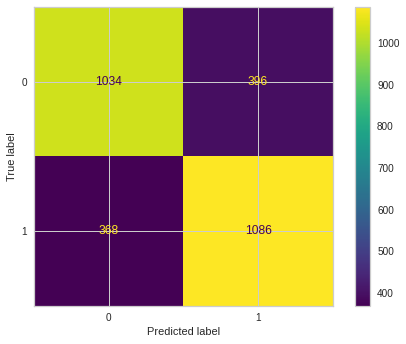

In [ ]:
feat_names = list(dict.fromkeys(feat_names))
df_pca = X_sm[feat_names].copy()
df_pca.insert(0, 'Y', Y_sm)
xgb_model = run_xgb(df_pca, 'After PCA')